# Bert Classifier for First ICU Prediction

## Import & Inits

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
import pickle
import torch

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler

from pytorch_pretrained_bert import BertTokenizer
from bert_classifier import read_df, train, evaluation, convert_examples_to_features

from utils.plots import *
from utils.metrics import BinaryAvgMetrics, get_best_model
from args import args
vars(args)

{'workdir': PosixPath('../data/work_dir/bert'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'bert_model': 'bert-base-mimic-cased',
 'modeldir': PosixPath('../data/work_dir/bert/models'),
 'bert_dir': PosixPath('../pretrained/pytorch-bert/bert-base-mimic-cased'),
 'max_seq_len': 256,
 'do_lower_case': False,
 'bs': 32,
 'device': 'cuda:0',
 'start_seed': 127,
 'cols': ['class_label', 'note'],
 'lr': 5e-05,
 'n_epochs': 7,
 'wd': 0.1,
 'warmup_prop': 0.1,
 'gradient_accumulation_steps': 3,
 'loss_scale': 0,
 'do_train': True,
 'do_eval': True,
 'bc_threshold': 0.3,
 'num_labels': 1,
 'labels': [0, 1],
 'n_gpu': 4}

## Threshold

In [4]:
with open(args.workdir/'one_run_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

targ,pred,prob = targs[0],preds[0],probs[0]

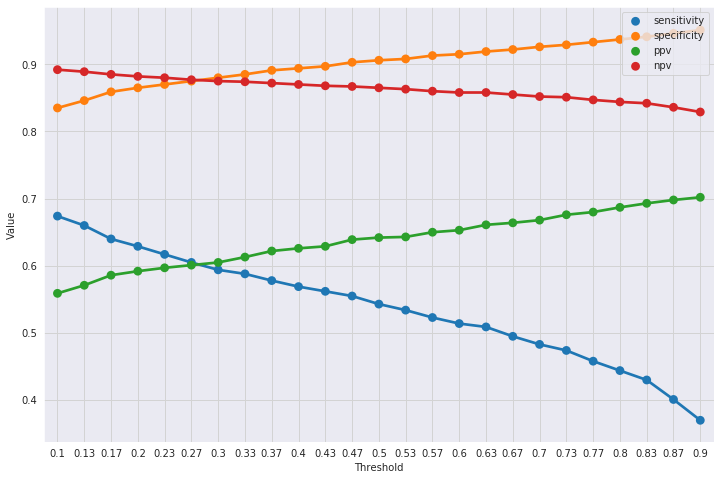

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, targ, prob, 0.1, 0.9, 25)

## Metrics

The models trained with training data that was split with seeds 159 and 169, whose predictions were found at index 32 and 42, had all their predictions at as class 1. This resulted in zero TN and FN and ended up with a NaN NPV. So, these were removed resulting in 98 runs instead of 100.

In [ ]:
with open(args.workdir/f'preds_ori.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

for i, (targ, pred, prob) in enumerate(zip(targs, preds, probs)):
  if np.all(pred == pred[0]):
    print(f"pred {pred[0]}, idx: {i}")

targs = [j for i, j in enumerate(targs) if i not in [32, 42]]
preds = [j for i, j in enumerate(preds) if i not in [32, 42]]
probs = [j for i, j in enumerate(probs) if i not in [32, 42]]

with open(args.workdir/f'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

In [ ]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)
  
fnames = [f'bert_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)] 

In [ ]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam

In [ ]:
get_best_model(bam, fnames)

In [ ]:
bam.get_avg_metrics()

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Run

In [ ]:
df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df['split'] = 'train'

train_examples = read_df(df.loc[(df['split'] == 'train')], 'note', 'class_label')
args.bs = args.bs // args.gradient_accumulation_steps
tokenizer = BertTokenizer.from_pretrained(args.bert_dir, do_lower_case=args.do_lower_case)

train_features = convert_examples_to_features(train_examples, args.labels, args.max_seq_len, tokenizer)

num_train_optimization_steps = int(len(train_examples) / args.bs /args.gradient_accumulation_steps)\
                              *args.n_epochs

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=args.bs,\
                              drop_last=True)

In [ ]:
loss = train(train_dataloader, num_train_optimization_steps, args)

In [ ]:
loss